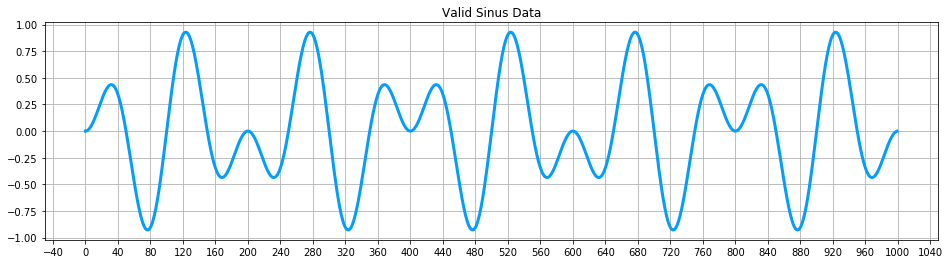

In [206]:
# Setting up packages for data manipulation and machine learning
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from keras.layers import LSTM, Dense, TimeDistributed, Dropout, Activation

# Creating the sample sinus curve dataset
steps = 1000
gradient = 0.002
list_a = []
for i in range(0, steps, 1):
    y = round(math.sin(math.pi * i * 0.02), 4) * round(math.sin(math.pi * i * 0.005), 4)
    list_a.append(y)
df = pd.DataFrame({"valid": list_a}, columns=["valid"])

# Visualizing the data
fig, ax1 = plt.subplots(figsize=(16, 4))
ax1.xaxis.set_major_locator(plt.MaxNLocator(30))
plt.title("Valid Sinus Data")
plt.plot(df[["valid"]], color="#039dfc", linewidth=3.0)
plt.grid()
plt.show()

In [224]:
# Settings
epochs = 1; batch_size = 1; lstm_neuron_number = 15

# Get the number of rows to train the model on 80% of the data
npdataset = df.values
training_data_length = math.ceil(len(npdataset) * 0.8)

# Transform features by scaling each feature to a range between 0 and 1
mmscaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = mmscaler.fit_transform(npdataset)

# Create a scaled training data set
train_data = scaled_data[0:training_data_length, :]

# Split the data into x_train and y_train data sets
x_train = []
y_train = []
trainingdatasize = len(train_data)
for i in range(lstm_neuron_number, trainingdatasize):
    x_train.append(
        train_data[i - lstm_neuron_number : i, 0]
    )  # contains lstm_neuron_number values 0-lstm_neuron_number
    y_train.append(train_data[i, 0])  # contains all other values

# Convert the x_train and y_train to numpy arrays
x_train = np.array(x_train)
y_train = np.array(y_train)

# Reshape the data
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
print("x_tain.shape: " + str(x_train.shape) + " -- y_tain.shape: " + str(y_train.shape))

# Configure and compile the neural network model
model1 = Sequential()
model1.add(
    LSTM(lstm_neuron_number, return_sequences=False, input_shape=(x_train.shape[1], 1))
)
model1.add(Dense(1))
model1.compile(optimizer="adam", loss="mean_squared_error")

# Create the test data set
test_data = scaled_data[training_data_length - lstm_neuron_number :, :]

# Create the data sets x_test and y_test
x_test = []
y_test = npdataset[training_data_length:, :]
for i in range(lstm_neuron_number, len(test_data)):
    x_test.append(test_data[i - lstm_neuron_number : i, 0])

# Train the model
history = model1.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)

x_tain.shape: (785, 15, 1) -- y_tain.shape: (785,)
Epoch 1/1
785/785 [==============================] - 5s 6ms/step - loss: 0.0127


In [225]:
# Reshape the data, so that we get an array with multiple test datasets
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# Get the predicted values
predictions = model1.predict(x_test)
predictions = mmscaler.inverse_transform(predictions)

# Get the root mean squarred error (RMSE) and the meadian error (ME)
rmse = np.sqrt(np.mean(predictions - y_test) ** 2)
me = np.median(y_test - predictions)
print("me: " + str(round(me, 4)) + ", rmse: " + str(round(rmse, 4)))

me: -0.0105, rmse: 0.0098


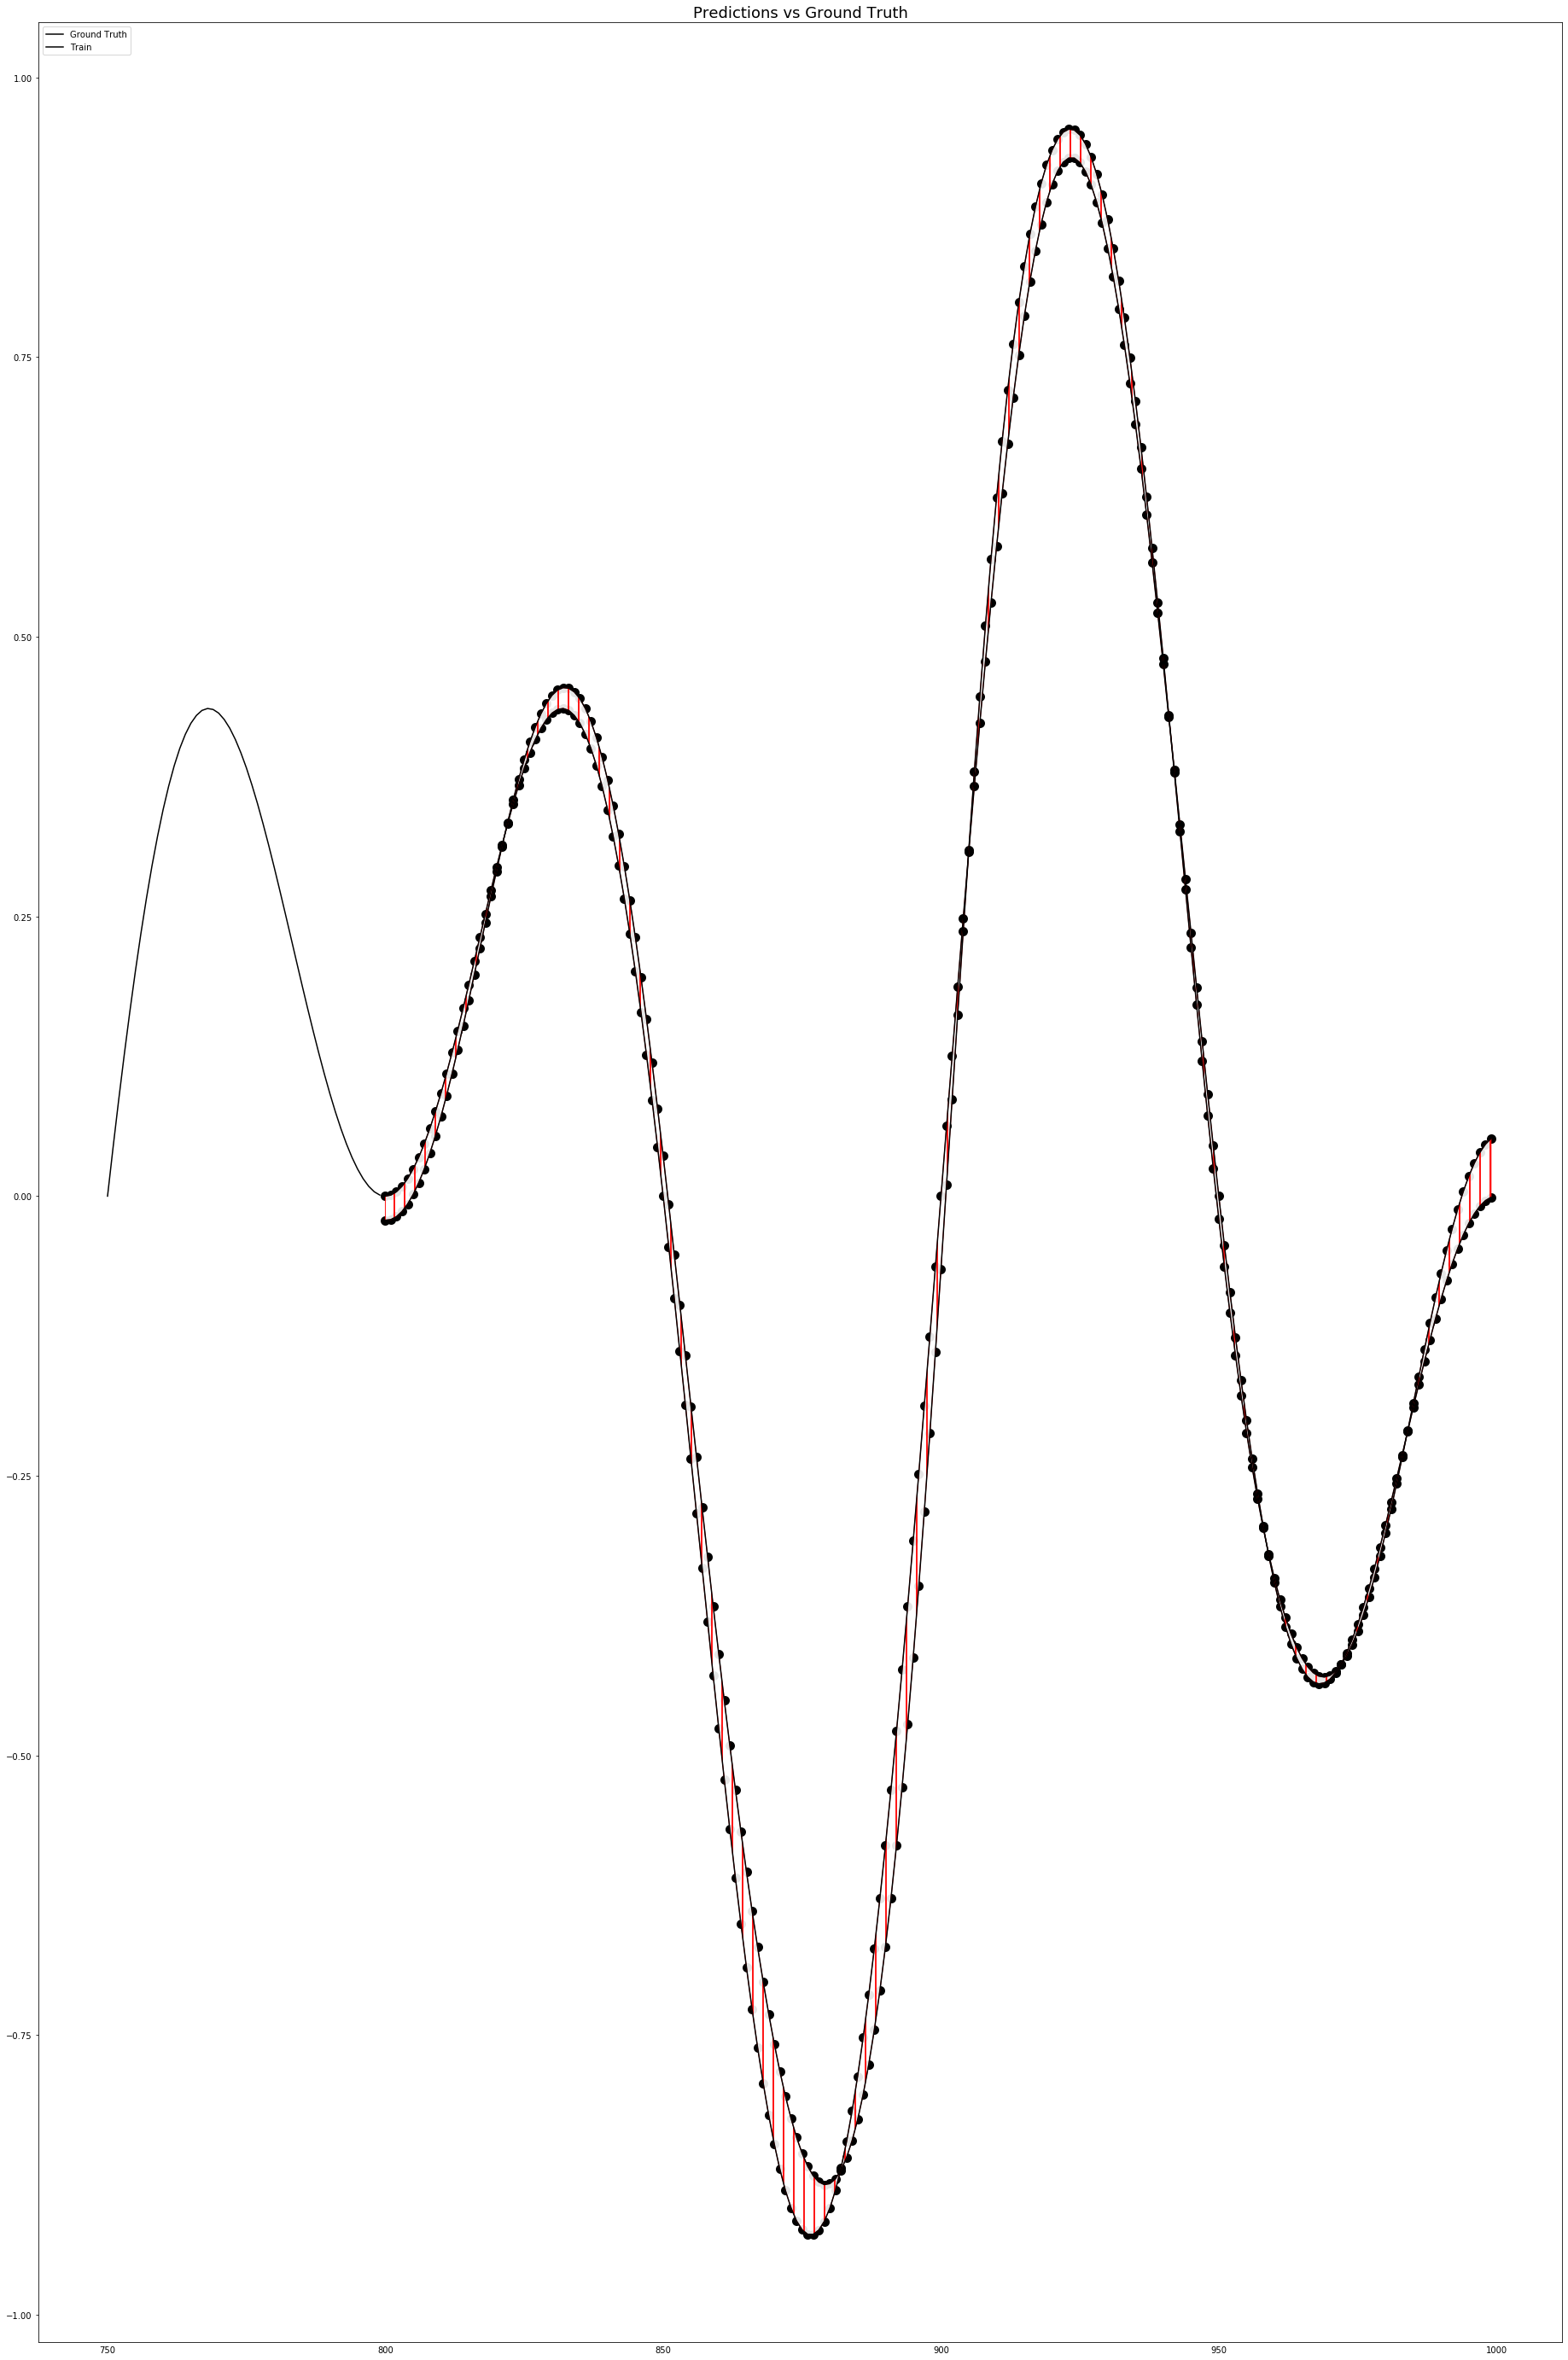

In [227]:
# Visualize the data
train = df[:training_data_length]
valid = df[training_data_length:]
valid.insert(1, "Predictions", predictions, True)
fig, ax1 = plt.subplots(figsize=(32, 50), sharex=True)
xt = valid.index
yt = train[["valid"]]
xv = valid.index
yv = valid[["valid", "Predictions"]]
ax1.tick_params(axis="x", rotation=0, labelsize=10, length=0)
plt.title("Predictions vs Ground Truth", fontsize=18)
plt.scatter(xv, yv["Predictions"], color="black", linewidth=5)
plt.plot(yv["Predictions"], color="black")
plt.plot(yv["valid"], color="black")
plt.scatter(xv, yv["valid"], color="black", linewidth=5)
plt.plot(yt["valid"][750:800], color="black")
plt.legend(["Ground Truth", "Train"], loc="upper left")


# Fill between plotlines
import matplotlib as mpl
mpl.rc('hatch', color='k', linewidth=2)
ax1.fill_between(xv, yv["valid"], yv["Predictions"],  facecolor = 'white', hatch="|",  edgecolor="red", alpha=.9) 
plt.show()

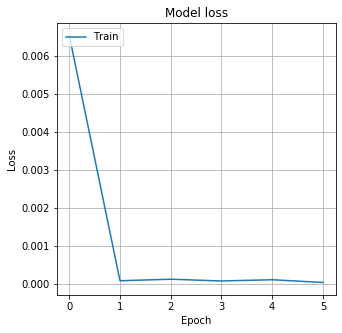

In [153]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(5, 5), sharex=True)
plt.plot(history.history["loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [154]:
# Settings and Model Labels
rolling_forecast_range = 30
titletext = "Forecast Chart Model A"
ms = [
    ["epochs", epochs],
    ["batch_size", batch_size],
    ["lstm_neuron_number", lstm_neuron_number],
    ["rolling_forecast_range", rolling_forecast_range],
    ["layers", "LSTM, DENSE(1)"],
]
settings_text = ""
lms = len(ms)
for i in range(0, lms):
    settings_text += ms[i][0] + ": " + str(ms[i][1])
    if i < lms - 1:
        settings_text = settings_text + ",  "

# Multi Prediction
new_df = df.filter(["valid"])
for i in range(0, rolling_forecast_range):
    last_values = new_df[-lstm_neuron_number:].values
    last_values_scaled = mmscaler.transform(last_values)
    X_input = []
    X_input.append(last_values_scaled)
    X_input = np.array(X_input)
    X_test = np.reshape(X_input, (X_input.shape[0], X_input.shape[1], 1))
    pred_value = model1.predict(X_input)
    pred_value_unscaled = mmscaler.inverse_transform(pred_value)
    pred_value_f = round(pred_value_unscaled[0, 0], 4)
    next_index = new_df.iloc[[-1]].index.values + 1
    new_df = new_df.append(pd.DataFrame({"valid": pred_value_f}, index=next_index))
    new_df_length = new_df.size
forecast = new_df[new_df_length - rolling_forecast_range : new_df_length].rename(
    columns={"valid": "Forecast"}
)

In [155]:
#Visualize the results
pred.index = pred.index
validxs = valid.copy()
dflen = new_df.size - 1
validxs.insert(2, "Forecast", forecast, True)
dfs = pd.concat([validxs, forecast], sort=False)
dfs.at[dflen, "Forecast"] = dfs.at[dflen, "Predictions"]

# Zoom in to a closer timeframe
dfs = dfs[dfs.index > 200]
yt = dfs[["valid"]]
yv = dfs[["Predictions"]]
yz = dfs[["Forecast"]]
xz = dfs[["Forecast"]].index

# Visualize the data
fig, ax1 = plt.subplots(figsize=(16, 5), sharex=True)
ax1.tick_params(axis="x", rotation=0, labelsize=10, length=0)
ax1.xaxis.set_major_locator(plt.MaxNLocator(30))
plt.title('Forecast Basic Model', fontsize=18)
plt.plot(yt, color="#039dfc", linewidth=1.5)
plt.plot(yv, color="#F9A048", linewidth=1.5)
plt.scatter(xz, yz, color="#F332E6", linewidth=1.0)
plt.plot(yz, color="#F332E6", linewidth=0.5)
plt.legend(["Ground Truth", "TestPredictions", "Forecast"], loc="upper left")
ax1.annotate('ModelSettings: ' + settings_text, xy=(0.06, .015),  xycoords='figure fraction', horizontalalignment='left', verticalalignment='bottom', fontsize=10)
plt.grid()
plt.show()

NameError: name 'pred' is not defined